# 0.课前准备

* Python
* Jupyter
* Git
* 数学基础（线性代数，微积分，最优化）

* 资源
    * [第一课官方视频：图像分类](https://course.fast.ai/videos/?lesson=1)
    * [带有英文字幕的第一课视频（无需vpn）:B站连接](https://www.bilibili.com/video/av41718196)
    * [官方资源和第一课的更新](https://forums.fast.ai/t/lesson-1-official-resources-and-updates/27936)
    * [视频详细说明](https://github.com/hiromis/notes/blob/master/Lesson1.md)
    * [官方代码库](https://github.com/fastai/course-v3)
    
    * [School-Of-AI北京学习官方论坛](https://forums.fast.ai/t/school-of-ai-beijing-study-group/43436)
    
    * fast.ai [课程网站](https://course.fast.ai) [论坛(需注册)](https://forums.fast.ai)

* [环境安装](https://github.com/fastai/fastai/blob/master/README.md#installation)
```shell
conda install -c pytorch -c fastai fastai
```

In [1]:
# jupyter环境配置；确保所有的编辑和库都会自动加载，图片和运行结果始终显示在笔记上
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
#  环境测试 import some libs
from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [4]:
a = 1
b = a + 1
c = b + a + 1
d = c + b + a + 1
a, b, c, d

(1, 2, 4, 8)

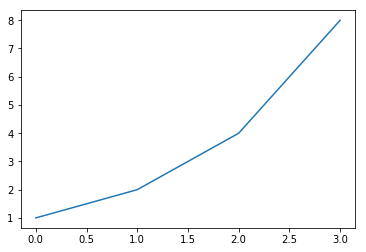

In [5]:
plt.plot([a,b,c,d])
plt.show()

# 1.宠物图片分类
本课的核心目标是训练一个图片分类器，将宠物种类识别做到最专业级的精确度。实验成功的关键是迁移学习 transfer learning，也是本课程的核心平台或模型模版工具之一. 我们会学习如何分析模型以理解错误发生所在。在此过程中，我们将看到模型犯错的地方，就连宠物种类鉴定专家也会判断出错。

本课程的授课模式，即自上而下，而非自下而上。也就是说，我们是从实验开始，根据需求，逐步深入学习理论，而非传统方式，讲完理论，才慢慢开始实践。这种方法对老师挑战较大非常耗时，但对学生受益颇丰。

我们还将讨论在训练模型时如何设置那些最重要的超参数hyper-parameter。我们将采用Leslie Smith's fantastic learning rate finder method来设置学习率。最后，我们将研究很少讨论但非常重要的labeling数据标记, 并学习fastai 库提供的轻松添加图片标注的功能。

##  需要使用的数据
我们将使用的是牛津的宠物数据集 [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) ,这个数据由12种猫和25种狗的特征图像组成。

我们的模型需要学会区分这37个不同的类别。根据他们的论文，他们在2012年能得到的最好的准确度是59.21%，使用了一个针对宠物检测的复杂模型，宠物照片有单独的“图像”、“头部”和“身体”模型。让我们看看使用深度学习有多精确！

我们将使用 **untar_data** 数据函数，我们必须将URL作为参数传递给它，它将下载和提取数据。

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [4]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

当我们处理一个问题时，首先要做的是查看数据。我们首先需要很好地理解问题是什么，以及数据是什么样子，然后才能找到解决问题的方法。查看数据意味着了解数据目录的结构、标签是什么以及一些示例图像的内容。

图像分类数据集处理的主要区别在于标签的存储方式。在这个特定的数据集中，标签存储在文件名中。我们需要提取它们，以便能够将图像分类为正确的类别。幸运的是，fastai库有一个非常方便的函数，**ImageDataBunch.from_name_re** 使用正则表达式从文件名中获取标签。

In [7]:
# 获取所有图片文件路径名称
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/zkzc-mcy/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [8]:
np.random.seed(2)
# 分类名称抽取正则表达式规则
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
# size=224 图片训练统一尺寸，也可设置较小数，越小训练越快，准确度降低；CPU模式下，内存8G和12G 224都跑不动，设为112时8G内存刚好够用
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=112)
# 标准化（统一尺寸为size=224）
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\zkzc-mcy\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\zkzc-mcy\.fastai\data\oxford-iiit-pet\images;

Test: None

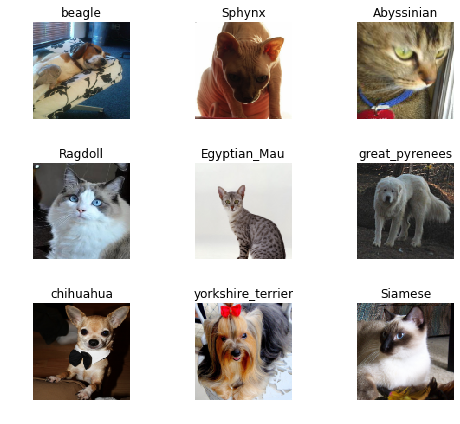

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 训练：resnet34

现在我们将开始培训我们的模型。我们将使用一个[卷积神经网络](http://cs231n.github.io/convolutional-networks/)主干和一个具有单个隐藏层的完全连接的头部作为分类器。不知道这些是什么意思？不用担心，我们将在接下来的课程中深入学习。目前，您需要知道我们正在构建一个模型，该模型将以图像作为输入，并输出每个类别的预测概率（在本例中，它将有37个输出）。 

我们将训练4个时期（epoch）（在所有数据中进行4个周期）。

> epoch这个概念指数据集中所有样本都跑一遍。迭代（iteration）是个batch_size跑一次。

In [12]:
# learn = ConvLearner(data, models.resnet34, metrics=error_rate)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.209929,0.921699,0.255074,18:29
1,1.189673,0.635065,0.196888,18:03
2,0.844537,0.569448,0.175237,17:22
3,0.692379,0.560755,0.173207,17:01


In [15]:
# 保存参数模型
learn.save('stage-1')
# 加载参数模型
# learn.load('stage-1'); 

## 结果

我们将首先看到模型最容易混淆的是哪些类别。我们将尝试看看模型预测的是否合理。在这种情况下，错误看起来是合理的（没有明显的错误是幼稚的）。这表明我们的分类器工作正常。

此外，当我们绘制混淆矩阵时，我们可以看到分布严重扭曲：模型一次又一次地犯同样的错误，但很少混淆其他类别。这表明，人们很难区分某些特定的类别；这是正常的行为。

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

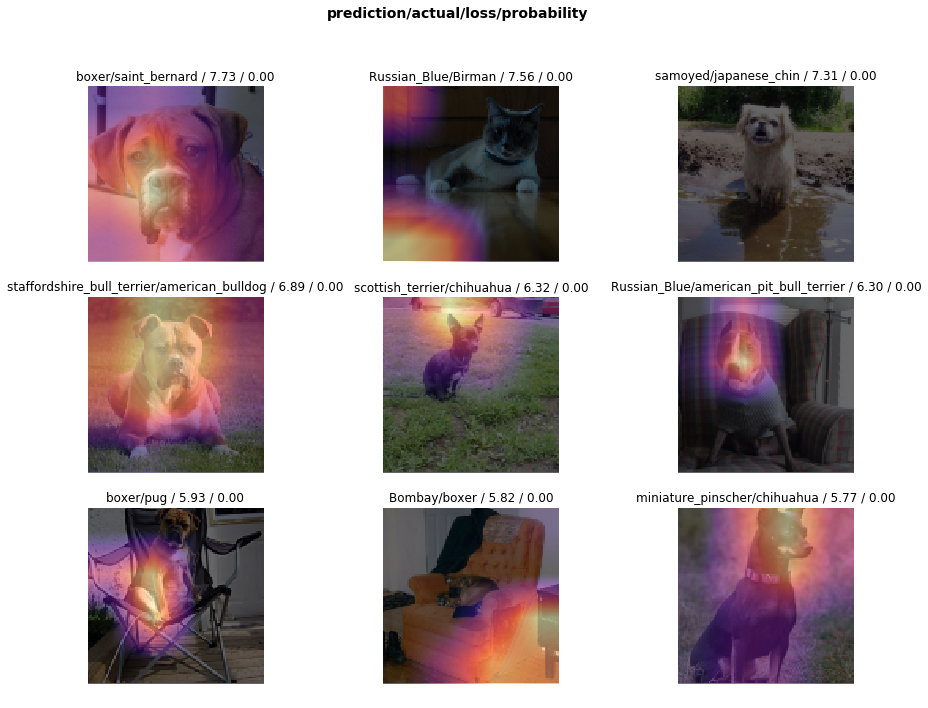

In [17]:
# 显示损失最高样本
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
# doc(interp.plot_top_losses)

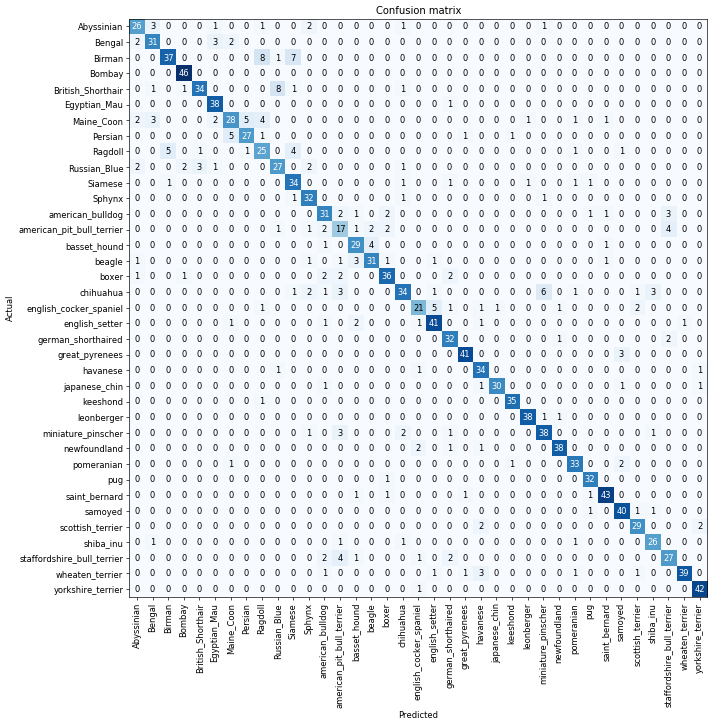

In [19]:
# 绘制混淆矩阵
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
# 列出混效率倒叙，第二个参数是最低混效率
interp.most_confused(min_val=3)

[('Birman', 'Ragdoll', 8),
 ('British_Shorthair', 'Russian_Blue', 8),
 ('Birman', 'Siamese', 7),
 ('chihuahua', 'miniature_pinscher', 6),
 ('Maine_Coon', 'Persian', 5),
 ('Persian', 'Maine_Coon', 5),
 ('Ragdoll', 'Birman', 5),
 ('english_cocker_spaniel', 'english_setter', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('Ragdoll', 'Siamese', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('basset_hound', 'beagle', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Abyssinian', 'Bengal', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('beagle', 'basset_hound', 3),
 ('chihuahua', 'american_pit_bull_terrier', 3),
 ('chihuahua', 'shiba_inu', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('wheaten_terrier', 'havanese', 3)]

# Unfreezing, fine-tuning, and learning rates（释放、微调和学习率）

为了我们的模型按预期工作，我们将释放我们的模型并进行更多的训练。

In [ ]:
# learn.unfreeze() # 释放模型
# learn.fit_one_cycle(1) # 重新训练

In [22]:
# learn.load('stage-1') # 如果前边有unfreeze操作，查看某个模型学习率需重新加载
learn.lr_find() # 学习率查看

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


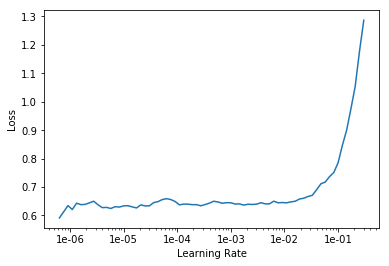

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
# 增加微调参数，截取较低的学习率
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
# 这是一个相当精确的模型！ 

epoch,train_loss,valid_loss,error_rate,time
0,0.613538,0.518757,0.158322,19:53
1,0.573705,0.513403,0.158322,19:49


# 训练resnet50

现在，我们将以与以前相同的方式进行培训，但有一个警告：我们将使用resnet50（resnet34是一个34层的残差网络，resnet50有50层），而不是使用resnet34作为主干。稍后将在课程中解释，您可以在[Resnet论文](https://arxiv.org/pdf/1512.03385.pdf)中了解详细信息）。

基本上，resnet50通常性能更好，因为它是一个参数更多的更深层次的网络。让我们看看能否在这里实现更高的性能。为了帮助它的发展，让我们也使用更大的图像，因为这样网络可以看到更多的细节。我们将批处理大小减小一点，因为否则这个更大的网络将需要更多的GPU内存。

In [ ]:
# 这个尺寸CPU很难跑
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),size=299, bs=bs//2).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(8)
# learn.save('stage-1-50')
# 可以准确地识别宠物品种真是令人惊讶！让我们看看完整的微调是否有帮助： 

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
# 如果没有，你可以回到以前的模型。

In [ ]:
learn.load('stage-1-50');
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

# 其他数据格式实验（手写数字识别）

In [25]:
path = untar_data(URLs.MNIST_SAMPLE); path

WindowsPath('C:/Users/zkzc-mcy/.fastai/data/mnist_sample')

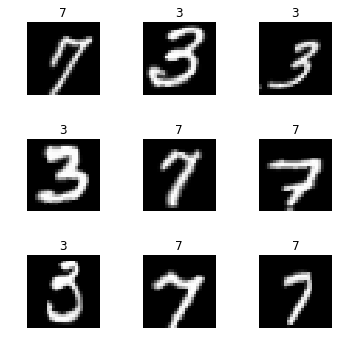

In [26]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)
data.show_batch(rows=3, figsize=(5,5))

In [27]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\zkzc-mcy/.torch\models\resnet18-5c106cde.pth
46827520it [00:19, 2460462.37it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.154671,0.087972,0.971050,03:45
1,0.092040,0.041512,0.987733,03:47


In [29]:
learn.save('num-stage-1')
learn.load('num-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: C:\Users\zkzc-mcy\.fastai\data\mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: C:\Users\zkzc-mcy\.fastai\data\mnist_sample;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
# df格式读取
df = pd.read_csv(path/'labels.csv')
df.head()
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
# csv数据读取
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
# 文件路径正则匹配读取
fn_paths = [path/name for name in df['name']]; fn_paths[:2]
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
# lambda表达式读取
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
# 列表读取
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes